In [1]:
%matplotlib inline

# An LSTM for Part-of-Speech Tagging
https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

### Load Data

In [4]:
import csv
Dataset = []
with open('Data/Parsed_simpletag.csv', newline='') as csvfile:
    csv_reader = csv.reader(csvfile, delimiter=',')
   
    data = []
    for row in csv_reader:
        
        if len(row) == 0:
            Dataset.append(data)
            data = []
        else:
            tag = [row[0], row[1], row[2]]
            data.append(tag)

### Make universal tagset!

In [7]:
# http://universaldependencies.org/u/pos/

uni = {
    # open
    'A': 'ADJ',
    'ADV': 'ADV',
    'INTJ': 'INTJ',
    'S': 'NOUN',
    'V': 'VERB',
    'INIT': 'PROPN', 
    
    # closed
    'PR': 'ADP',
    #'': 'AUX', ### not in Russian
    'CONJ': 'CONJ', # 'CCONJ', 'SCONJ'
    'APRO': 'DET',
    'NUM': 'NUM',
    'PART': 'PART',
    'SPRO': 'PRON',
    
    # other
    'PUNCT': 'PUNCT',
    'NONLEX': 'X',
        
    # dop
    'ADVPRO': 'ADV',
    'ANUM': 'ADJ',
    'PARENTH': 'ADV',  # Вводное слово
    'PRAEDIC': 'VERB',
    'PRAEDICPRO': 'VERB'
}

In [8]:
for sentence in Dataset:
    for word in sentence:
        
        tag = uni[word[2]]
        word.pop(2)
        word.append(tag)

## Prepare data!

In [5]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

In [41]:
use_lemms = 1

data = []
for sentence in Dataset:
    sentence_data = []
    words = []
    tags = []
    for word in sentence:
        words.append(word[use_lemms])
        tags.append(word[2])
    
    sentence_data.append(words)
    sentence_data.append(tags)
    
    sentence_data = tuple(sentence_data)
    data.append(sentence_data)
    
print('num of sentences:', len(data))

num of sentences: 87782


In [7]:
data[100:105]

[(['нет', '.'], ['PART', 'PUNCT']),
 (['один', 'только', 'кусочек', 'холодный', 'остаться', '.'],
  ['ANUM', 'PART', 'S', 'A', 'V', 'PUNCT']),
 (['В', '..'], ['INIT', 'PUNCT']),
 (['давайте', 'погреть', '.'], ['PART', 'V', 'PUNCT']),
 (['Б', '..'], ['INIT', 'PUNCT'])]

## Make w2v!!!

In [8]:
import gensim
from pymystem3 import Mystem
#import pymorphy2
from ufal.udpipe import Model, Pipeline

word_vectors = gensim.models.KeyedVectors.load_word2vec_format("/home/r/Documents/data_w2v/tenth.norm-sz500-w7-cb0-it5-min5.w2v", 
                                                               binary=True, unicode_errors='ignore')

print(word_vectors.vectors.shape)

(2641862, 500)


In [9]:
path = 'udpipes/'
modelfile1 = 'russian-syntagrus-ud-2.3-181115.udpipe'
modelfile2 = 'russian-gsd-ud-2.3-181115.udpipe'
modelfile3 = 'russian-taiga-ud-2.3-181115.udpipe'

model1 = Model.load(path + modelfile1)
model2 = Model.load(path + modelfile2)
model3 = Model.load(path + modelfile3)

In [10]:
def tag_ufal(word, model):
    
    pipeline = Pipeline(model, 'tokenize', Pipeline.DEFAULT, Pipeline.DEFAULT, 'conllu')
    processed = pipeline.process(word)
    output = [l for l in processed.split('\n') if not l.startswith('#')]
    tagged = ['_'.join(w.split('\t')[2:4]) for w in output if w]
    tagged = [w.split('\t')[2] for w in output if w]

    if len(tagged) > 1:
        pass
        #print('MANY tags!')
        #print(word, tagged)
    return tagged[0]

In [14]:
word_vectors['vector']

array([-0.18125933,  0.04451561,  0.04566395, -0.08743411,  0.06082746,
        0.3114289 , -0.27108607,  0.12590593,  0.27222472,  0.4354773 ,
       -0.14616688, -0.1757782 ,  0.0132714 , -0.15076365,  0.07179581,
       -0.16493756, -0.03184904, -0.39687994,  0.02206128, -0.0151894 ,
       -0.08458586, -0.12455434,  0.08239872,  0.15433611,  0.36637557,
       -0.14813724, -0.00548346,  0.0207062 , -0.11735547, -0.07771657,
       -0.23354442, -0.05254282, -0.01529887, -0.00365412,  0.05576355,
        0.10970679, -0.06045992,  0.2756294 ,  0.35827807,  0.19157635,
       -0.15099981, -0.04767626,  0.11978843, -0.1600945 , -0.21727917,
       -0.10526314,  0.14590985, -0.3157325 , -0.00958069,  0.1108558 ,
        0.12626551,  0.03842518,  0.0819481 , -0.00221886,  0.2589593 ,
       -0.07106131,  0.01050402, -0.03745199,  0.04808694,  0.09731693,
       -0.00947738, -0.11228902,  0.40869322, -0.3294705 ,  0.22165246,
        0.02771976, -0.16267037,  0.13831954, -0.06457084,  0.19

### extract vectors!

In [15]:
repair = {
    '0': 'ноль',
    '1': 'один',
    '2': 'два',
    '3': 'три',
    '4': 'четыре',
    '5': 'пять',
    '6': 'шесть',
    '7': 'семь',
    '8': 'восемь',
    '9': 'девять',
    '10': 'десять',
    ':': '-',
    ';': ',',
    ':"': '-',
    
}

In [42]:
w2v_data = []

faild_words = []
faild_tags = []

for i, sentence in enumerate(data):
    
    if i % 5000 == 0:
        print('iter =', i)
    #print(sentence)
    
    flag = True
    
    new_sentence = []
    for i, word in enumerate(sentence[0]):
        
        word = word.lower()
        
        # repair some words!
        if word in list(repair.keys()):
            word = repair[word]
        if word.count('-') == 1 and len(word) != 1:
            ind = word.index('-')
            word = word[:ind] + word[ind + 1:]
            
        for letter in word:
            if ord(letter) >= 97 and ord(letter) <= 122 or \
            ord(letter) >= 65 and ord(letter) <= 90:
                word = 'vector'
        
        # try-excepts for
        try:
            word_vectors[word]
            new_sentence.append(word)
            
        except KeyError:
            try:
                tag = tag_ufal(word, model1)
                word_vectors[tag]
                new_sentence.append(tag)
            except KeyError:
                try:
                    tag = tag_ufal(word, model2)
                    word_vectors[tag]
                    new_sentence.append(tag)
                except KeyError:
                    try:
                        tag = tag_ufal(word, model3)
                        word_vectors[tag]
                        new_sentence.append(tag)
                    except KeyError:
                        faild_words.append(word)
                        faild_tags.append(sentence[1][i])
                        flag = False
    
    if flag == True:
        w2v_data.append((new_sentence, sentence[1]))


iter = 0
iter = 5000
iter = 10000
iter = 15000
iter = 20000
iter = 25000
iter = 30000
iter = 35000
iter = 40000
iter = 45000
iter = 50000
iter = 55000
iter = 60000
iter = 65000
iter = 70000
iter = 75000
iter = 80000
iter = 85000


In [43]:
data = w2v_data
len(data)

77098

## REAPIR!

In [21]:
# create dicts!

failw = {}
for fail in faild_words:
    try:
        failw[fail] += 1
    except:
        failw[fail] = 1     
        
failt = {}
for fail in faild_tags:
    try:
        failt[fail] += 1
    except:
        failt[fail] = 1

In [22]:
sorted_x = sorted(failw.items(), key=lambda kv: kv[1], reverse=True)
sorted_x

[('«', 528),
 ('»', 235),
 ('20', 225),
 ('12', 214),
 ('15', 206),
 ('2002', 202),
 ('2003', 184),
 ('30', 179),
 ('11', 177),
 ('50', 154),
 ('».', 153),
 ('2001', 152),
 ('14', 150),
 ('25', 143),
 ('40', 138),
 ('18', 134),
 ('16', 130),
 ('|', 129),
 ('13', 128),
 ('2000', 124),
 ('17', 118),
 ('22', 111),
 ('19', 110),
 ('100', 108),
 ('»,', 99),
 ('21', 95),
 (':--', 91),
 ('24', 90),
 ('=', 90),
 ('60', 87),
 ('00', 84),
 ('1995', 75),
 ('70', 74),
 ('1998', 69),
 ('27', 68),
 ('23', 68),
 ('28', 67),
 ('1999', 63),
 ('45', 61),
 ('2004', 61),
 ('элуцидарий', 59),
 ('35', 58),
 ('26', 58),
 ('500', 57),
 ('29', 57),
 ('33', 52),
 ('90', 52),
 ('1996', 51),
 ('36', 50),
 ('39', 49),
 ('300', 48),
 ('\x95', 47),
 ('80', 45),
 ('150', 44),
 ('1997', 43),
 ('01', 43),
 ('заработный', 42),
 ('32', 41),
 ('37', 41),
 ('31', 41),
 ('1994', 41),
 ('1991', 39),
 ('200', 38),
 ('яэу', 38),
 ('30й', 37),
 ('38', 37),
 ('48', 36),
 ('дебоширин', 36),
 ('*', 36),
 ('34', 34),
 ('пелипейко',

In [23]:
sorted_y = sorted(failt.items(), key=lambda kv: kv[1], reverse=True)
sorted_y

[('NUM', 8628),
 ('S', 3261),
 ('A', 2169),
 ('PUNCT', 1707),
 ('ANUM', 556),
 ('V', 305),
 ('ADV', 94),
 ('NONLEX', 80),
 ('PART', 27),
 ('INTJ', 19),
 ('ADVPRO', 7),
 ('APRO', 6),
 ('PRAEDIC', 1),
 ('PARENTH', 1),
 ('SPRO', 1)]

In [44]:
# create dicts!

word_to_ix = {}
tag_to_ix = {}
for sent, tags in data:
    for word in sent:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)
            
    for tag in tags:
        if tag not in tag_to_ix:
            tag_to_ix[tag] = len(tag_to_ix)        
print(len(word_to_ix), len(tag_to_ix))

37045 19


In [45]:
tag_to_ix

{'PUNCT': 0,
 'NUM': 1,
 'V': 2,
 'S': 3,
 'PARENTH': 4,
 'PART': 5,
 'CONJ': 6,
 'APRO': 7,
 'SPRO': 8,
 'A': 9,
 'ADVPRO': 10,
 'ADV': 11,
 'PR': 12,
 'PRAEDIC': 13,
 'INTJ': 14,
 'ANUM': 15,
 'INIT': 16,
 'NONLEX': 17,
 'PRAEDICPRO': 18}

In [46]:
# create dicts!

tag_count = {}
for sent, tags in data:

    for tag in tags:
        
        try:
            tag_count[tag] += 1
        except:
            tag_count[tag] = 1       


In [47]:
tag_count

{'PUNCT': 203016,
 'NUM': 12909,
 'V': 121230,
 'S': 214176,
 'PARENTH': 4153,
 'PART': 36821,
 'CONJ': 60130,
 'APRO': 37938,
 'SPRO': 62164,
 'A': 65753,
 'ADVPRO': 18958,
 'ADV': 32111,
 'PR': 75795,
 'PRAEDIC': 6792,
 'INTJ': 884,
 'ANUM': 2772,
 'INIT': 2255,
 'NONLEX': 4467,
 'PRAEDICPRO': 80}

In [65]:
defolt = {
    'PUNCT': 2.2370374970060944,
    'V': 1.9358421145183762,
    'S': 2.436369946208572,
    'PARENTH': 2.0273037542662116,
    'PART': 1.6820133295171116,
    'CONJ': 1.9839136183340678,
    'APRO': 1.937685587640401,
    'SPRO': 1.668256594957656,
    'A': 2.2001774173108606,
    'ADVPRO': 1.7681992337164751,
    'ADV': 1.9197934072611271,
    'PR': 2.2666121686324887,
    'PRAEDIC': 1.6355748373101953,
    'NUM': 8.18313953488372,
    'ANUM': 2.602914389799636,
    'INIT': 4.751009421265142,
    'INTJ': 1.5388349514563107,
    'PRAEDICPRO': 1.4576271186440677,
    'NONLEX': 14.302439024390244
    
}

In [68]:
sorted_x = sorted(defolt.items(), key=lambda kv: kv[1], reverse=True)
sorted_x

[('NONLEX', 14.302439024390244),
 ('NUM', 8.18313953488372),
 ('INIT', 4.751009421265142),
 ('ANUM', 2.602914389799636),
 ('S', 2.436369946208572),
 ('PR', 2.2666121686324887),
 ('PUNCT', 2.2370374970060944),
 ('A', 2.2001774173108606),
 ('PARENTH', 2.0273037542662116),
 ('CONJ', 1.9839136183340678),
 ('APRO', 1.937685587640401),
 ('V', 1.9358421145183762),
 ('ADV', 1.9197934072611271),
 ('ADVPRO', 1.7681992337164751),
 ('PART', 1.6820133295171116),
 ('SPRO', 1.668256594957656),
 ('PRAEDIC', 1.6355748373101953),
 ('INTJ', 1.5388349514563107),
 ('PRAEDICPRO', 1.4576271186440677)]

### Train_test split

In [48]:
from sklearn.model_selection import train_test_split
num_of_test = 0.2

train_data, test_data = train_test_split(data, test_size = num_of_test, random_state = 12345)
print(len(train_data), len(test_data))

61678 15420


# Train the model:



In [49]:
class LSTMTagger(nn.Module):

    def __init__(self, hidden_dim1, hidden_dim2, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim1 = hidden_dim1
        self.hidden_dim2 = hidden_dim2
        
        #self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim1.
        self.lstm = nn.LSTM(500, hidden_dim1, bidirectional=True)

        self.lstm2 = nn.LSTM(hidden_dim1 * 2, hidden_dim2, bidirectional=True)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim2 * 2, tagset_size)
        self.hidden1 = self.init_hidden1()
        self.hidden2 = self.init_hidden2()

    def init_hidden1(self):

        return (torch.zeros(2, 1, self.hidden_dim1),
                torch.zeros(2, 1, self.hidden_dim1))

    def init_hidden2(self):

        return (torch.zeros(2, 1, self.hidden_dim2),
                torch.zeros(2, 1, self.hidden_dim2))

    def forward(self, sentence):
        
        lstm_out, self.hidden = self.lstm(
            sentence, self.hidden1)

        lstm_out2, self.hidden = self.lstm2(
            lstm_out.view(len(sentence), 1, -1), self.hidden2)

        tag_space = self.hidden2tag(lstm_out2.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

## Funcs

In [50]:
def train(sentence, tag):
    model.zero_grad()

    sentence_in = torch.Tensor(word_vectors[sentence])
    sentence_in = sentence_in.view(len(sentence), 1, -1)
    
    targets = prepare_sequence(tag, tag_to_ix)

    # forward pass
    tag_scores = model(sentence_in)

    # loss and backward
    loss = loss_function(tag_scores, targets)
    
    loss.backward()
    
    loss.detach_()
    optimizer.step()
        
    return tag_scores, loss

In [51]:
from sklearn.metrics import accuracy_score

def evaluate(num_iter = 100):
    with torch.no_grad():
        
        main_score = 0
        for i in range(num_iter):
            rng = np.random.randint(len(test_data))
            
            sentence = test_data[rng][0]
            
            sentence_in = torch.Tensor(word_vectors[sentence])
            sentence_in = sentence_in.view(len(sentence), 1, -1)

            output = model(sentence_in)
            
            # get top
            topv, topi = output.topk(1)
            true_values = prepare_sequence(test_data[rng][1], tag_to_ix)

            score = accuracy_score(true_values, topi)
            main_score += score

        
        return main_score / num_iter

In [52]:
def total_evaluate():
    with torch.no_grad():
        
        main_score = 0
        for i in range(len(test_data)):
            sentence = test_data[i][0]
            sentence_in = torch.Tensor(word_vectors[sentence])
            sentence_in = sentence_in.view(len(sentence), 1, -1)

            output = model(sentence_in)

            # get top
            topv, topi = output.topk(1)
            true_values = prepare_sequence(test_data[i][1], tag_to_ix)

            score = accuracy_score(true_values, topi)
            main_score += score

        
        return main_score / len(test_data)

In [53]:
def train_rng():
    
    rng = np.random.randint(len(train_data))
    
    sentence = train_data[rng][0]
    tag = train_data[rng][1]
    
    return sentence, tag

In [54]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

## GONNA TRAIN!

In [55]:
HIDDEN_DIM = 300
HIDDEN_DIM2 = 300

model = LSTMTagger(HIDDEN_DIM, HIDDEN_DIM2, len(tag_to_ix))
loss_function = nn.NLLLoss()

all_losses = []

In [ ]:
learning_rate = 0.1

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

n_iters = 20000 

plot_every = 100
print_every = 300

current_loss = 0
start = time.time()

model.hidden1 = model.init_hidden1()
model.hidden2 = model.init_hidden2()

for i in range(1, n_iters + 1):
        
    se, tag = train_rng()
    out, loss = train(se, tag)
    current_loss += loss
    
    if i % print_every == 0:
        print('%d %d%% (%s) loss: %.4f accuracy on test: %.4f' % (i, i / n_iters * 100, 
                                                                  timeSince(start), current_loss / plot_every, evaluate()))
    
    if i % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

300 1% (0m 26s) loss: 2.1193 accuracy on test: 0.3116
600 3% (0m 53s) loss: 2.0118 accuracy on test: 0.3295
900 4% (1m 19s) loss: 1.7515 accuracy on test: 0.5235
1200 6% (1m 45s) loss: 1.5197 accuracy on test: 0.5494
1500 7% (2m 10s) loss: 1.1873 accuracy on test: 0.6494
1800 9% (2m 35s) loss: 0.8410 accuracy on test: 0.7386
2100 10% (3m 1s) loss: 0.6839 accuracy on test: 0.7689
2400 12% (3m 27s) loss: 0.6683 accuracy on test: 0.8479
2700 13% (3m 54s) loss: 0.4990 accuracy on test: 0.8626
3000 15% (4m 22s) loss: 0.4131 accuracy on test: 0.8701
3300 16% (4m 47s) loss: 0.4322 accuracy on test: 0.8657
3600 18% (5m 13s) loss: 0.3317 accuracy on test: 0.8578
3900 19% (5m 36s) loss: 0.3083 accuracy on test: 0.8670
4200 21% (5m 58s) loss: 0.3561 accuracy on test: 0.8913
4500 22% (6m 22s) loss: 0.3285 accuracy on test: 0.9220


In [ ]:
import matplotlib.pyplot as plt

print(total_evaluate())

plt.plot(all_losses)
plt.show()

In [ ]:
learning_rate = 0.01

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

n_iters = 15000 

plot_every = 100
print_every = 300

current_loss = 0
start = time.time()

model.hidden1 = model.init_hidden1()
model.hidden2 = model.init_hidden2()

for i in range(1, n_iters + 1):
        
    se, tag = train_rng()
    out, loss = train(se, tag)
    current_loss += loss
    
    if i % print_every == 0:
        print('%d %d%% (%s) loss: %.4f accuracy on test: %.4f' % (i, i / n_iters * 100, 
                                                                  timeSince(start), current_loss / plot_every, evaluate()))
    
    if i % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

In [ ]:
import matplotlib.pyplot as plt

print(total_evaluate())

plt.plot(all_losses)
plt.show()

In [ ]:
learning_rate = 0.001

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

n_iters = 10000 

plot_every = 100
print_every = 300

current_loss = 0
start = time.time()

model.hidden1 = model.init_hidden1()
model.hidden2 = model.init_hidden2()

for i in range(1, n_iters + 1):
        
    se, tag = train_rng()
    out, loss = train(se, tag)
    current_loss += loss
    
    if i % print_every == 0:
        print('%d %d%% (%s) loss: %.4f accuracy on test: %.4f' % (i, i / n_iters * 100, 
                                                                  timeSince(start), current_loss / plot_every, evaluate()))
    
    if i % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

In [ ]:
import matplotlib.pyplot as plt

print(total_evaluate())

plt.plot(all_losses)
plt.show()

## Save and load models

In [34]:
path = 'Data/Models/LSTM_w2v_500'

torch.save(model.state_dict(), path)

In [27]:
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix))
model.load_state_dict(torch.load(path))
model.eval()

LSTMTagger(
  (word_embeddings): Embedding(50806, 64)
  (lstm): LSTM(64, 128)
  (hidden2tag): Linear(in_features=128, out_features=19, bias=True)
)

## confusion matrix

In [36]:
all_categories = list(tag_to_ix)
n_categories = len(all_categories)

# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories) 

n_confusion = 1000
y_train = []
y_test = []
with torch.no_grad():
    for i in range(len(test_data)):
        try:
            
            sentence = test_data[i][0]
            
            sentence_in = np.empty((len(sentence), 500))
            for j in range(len(sentence)):
                sentence_in[j] = word_vectors[sentence[j]]

            sentence_in = torch.Tensor(sentence_in)
            sentence_in = sentence_in.view(len(sentence), 1, -1)

            output = model(sentence_in)

            # get top
            topv, topi = output.topk(1)
            true_values = prepare_sequence(test_data[i][1], tag_to_ix)

            for j in range(len(true_values)):
                confusion[true_values[j]][topi[j]] += 1 # инк ячейку
                y_train.append(topi[j].item())
                y_test.append(true_values[j].item())
        except RuntimeError:
            pass
            
normalize_confusion = torch.clone(confusion)
# Normalize 
for i in range(n_categories):
    normalize_confusion[i] = normalize_confusion[i] / normalize_confusion[i].sum()

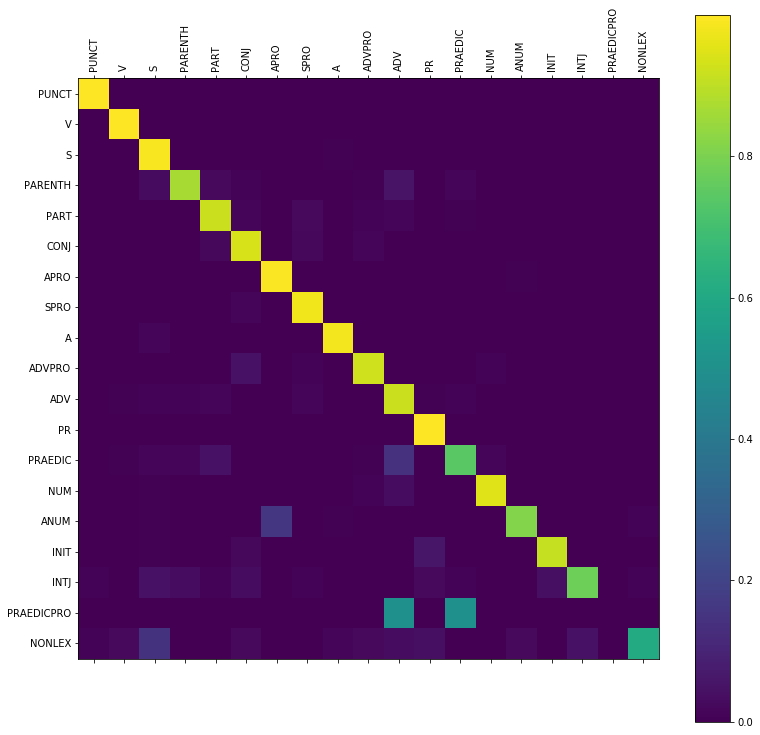

In [37]:
from matplotlib import ticker

# Set up plot
fig = plt.figure(figsize=(13, 13))
ax = fig.add_subplot(111)
cax = ax.matshow(normalize_confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

In [41]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

a = classification_report(y_test, y_train, target_names = [str(K) for K in list(tag_to_ix.keys())])

print(a)

              precision    recall  f1-score   support

       PUNCT       1.00      1.00      1.00     22721
           V       1.00      1.00      1.00     14807
           S       0.99      0.99      0.99     22834
     PARENTH       0.84      0.87      0.86       469
        PART       0.94      0.92      0.93      4969
        CONJ       0.95      0.94      0.95      7313
        APRO       0.99      0.99      0.99      4673
        SPRO       0.96      0.98      0.97      8316
           A       0.98      0.98      0.98      7964
      ADVPRO       0.93      0.93      0.93      2377
         ADV       0.91      0.92      0.92      4016
          PR       0.99      1.00      1.00      8490
     PRAEDIC       0.89      0.74      0.81       934
         NUM       0.92      0.95      0.93       601
        ANUM       0.90      0.81      0.85       295
        INIT       0.92      0.91      0.91       178
        INTJ       0.83      0.78      0.81       123
  PRAEDICPRO       0.00    

/home/r/anaconda3/envs/mainenv/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


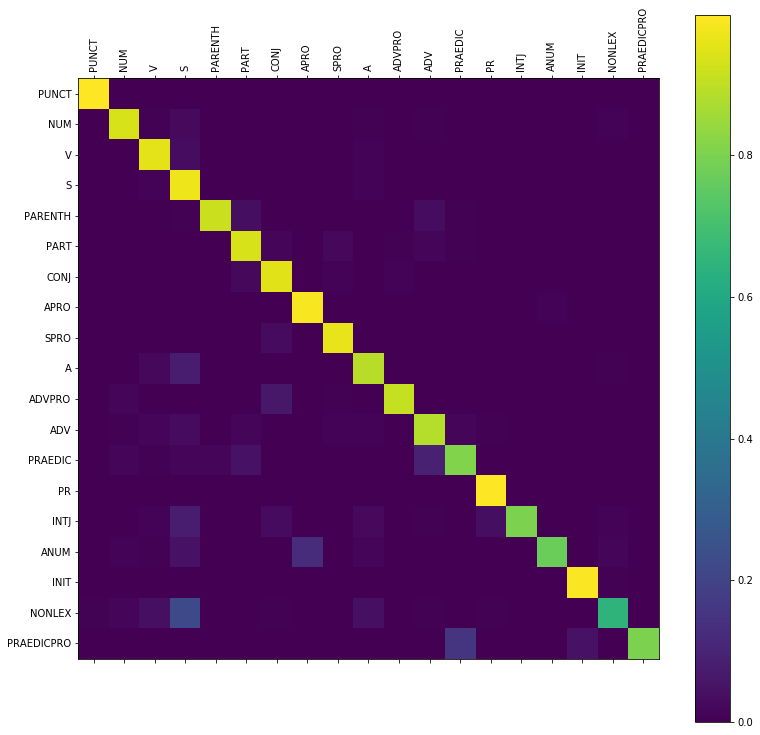

In [24]:
from matplotlib import ticker

# Set up plot
fig = plt.figure(figsize=(13, 13))
ax = fig.add_subplot(111)
cax = ax.matshow(normalize_confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

In [26]:
all_perc = 0
for i in range(n_categories):
    
    percent = normalize_confusion[i][i][0]
    all_perc += percent
    
    print(normalize_confusion[i][i], confusion[i][i])
    
print(all_perc / (n_categories - 1))

/home/r/.conda/envs/mainpy/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  after removing the cwd from sys.path.


tensor(0.9978) tensor(50858.)
tensor(0.9377) tensor(4832.)
tensor(0.9555) tensor(27500.)
tensor(0.9717) tensor(55233.)
tensor(0.9166) tensor(879.)
tensor(0.9364) tensor(7797.)
tensor(0.9539) tensor(13732.)
tensor(0.9881) tensor(8942.)
tensor(0.9639) tensor(13042.)
tensor(0.8899) tensor(15591.)
tensor(0.9111) tensor(3833.)
tensor(0.8861) tensor(6665.)
tensor(0.8080) tensor(1254.)
tensor(0.9957) tensor(19441.)
tensor(0.8020) tensor(158.)
tensor(0.7721) tensor(654.)
tensor(0.9902) tensor(710.)
tensor(0.6508) tensor(1055.)
tensor(0.8000) tensor(16.)
tensor(0.9515)


In [40]:
all_perc = 0
for i in range(n_categories):
    
    percent = normalize_confusion[i][i].item()
    all_perc += percent
    
    print(normalize_confusion[i][i], confusion[i][i])
    
print(all_perc / (n_categories - 1))

tensor(0.9999) tensor(22718.)
tensor(0.9983) tensor(14782.)
tensor(0.9905) tensor(22618.)
tensor(0.8699) tensor(408.)
tensor(0.9207) tensor(4575.)
tensor(0.9402) tensor(6876.)
tensor(0.9944) tensor(4647.)
tensor(0.9769) tensor(8124.)
tensor(0.9824) tensor(7824.)
tensor(0.9272) tensor(2204.)
tensor(0.9206) tensor(3697.)
tensor(0.9961) tensor(8457.)
tensor(0.7441) tensor(695.)
tensor(0.9517) tensor(572.)
tensor(0.8136) tensor(240.)
tensor(0.9101) tensor(162.)
tensor(0.7805) tensor(96.)
tensor(0.) tensor(0.)
tensor(0.6098) tensor(75.)
0.9070583879947662


In [71]:
test_data[5][1]

['CONJ', 'S', 'ADV', 'V', 'PUNCT', 'PR', 'S', 'V', 'A', 'S', 'PUNCT']

In [71]:
for sentence in test_data:
    for i in range(len(sentence[0])):
        if sentence[1][i] == 'NUM':
            #print(sentence[0])
            print(sentence[0][i])
            #print()

двое
несколько
столько
несколько
немного
два
два
два
два
много
мало
много
пять
много
пять
два
три
пол
три
два
сколько
несколько
трое
пятеро
много
мало
два
три
четыре
много
много
два
сколько
много
шесть
шесть
много
мало
двое
сколько
полтора
много
много
два
два
два
десять
мало
немножечко
столько
сколько
столько
девять
семь
десять
немало
три
много
несколько
три
три
три
сколько
два
два
много
несколько
два
семьсот
несколько
шесть
несколько
пять
сколько
два
сто
много
сколько
восемнадцать
два
три
несколько
четыре
полтора
два
много
два
два
два
десять
несколько
оба
оба
много
четыре
много
четыре
два
три
столько
несколько
четыре
два
три
много
много
два
шестнадцать
сколько
два
много
два
много
два
три
четыре
три
сорок
несколько
много
два
много
два
два
много
много
несколько
три
два
мало
много
тридцать
шесть
сколько
много
несколько
много
немного
полтора
сколько
два
несколько
много
тридцать
пол
четыре
мало
сто
много
много
много
три
двадцать
пять
мало
мало
мало
девять
четверо
тридцать
тридцать
три
два
